# Phase 2: Dimensionality Reduction & Feature Selection

This notebook performs advanced dimensionality reduction and feature selection to reduce noise, improve training efficiency, and identify the most influential factors driving air quality (AQI).

### What We’ll Cover:
- PCA (Principal Component Analysis)
- Autoencoders (deep learning-based feature reduction)
- Random Forest Feature Importances


In [ ]:
# Dimensionality Reduction - PCA, Autoencoders, Feature Importance

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

# Load feature engineered data
df = pd.read_csv('../data/feature_engineered_data.csv', parse_dates=['Date'])
df.set_index('Date', inplace=True)

# Drop non-numeric columns
df_numeric = df.select_dtypes(include=[np.number])

print("Shape of numeric data:", df_numeric.shape)


Shape of numeric data: (3650, 49)


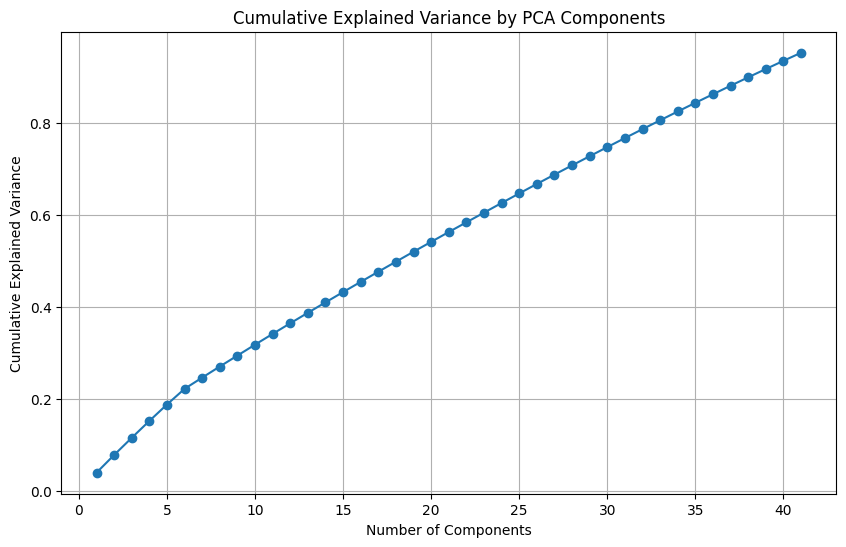

PCA complete: Saved to '../data/pca_features.csv'


In [2]:
# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_numeric)

# Run PCA
pca = PCA(n_components=0.95)  # Keep 95% variance
pca_features = pca.fit_transform(scaled_data)

# Explained variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance)+1), explained_variance, marker='o')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Save PCA features
pca_df = pd.DataFrame(pca_features, index=df.index)
pca_df.to_csv('../data/pca_features.csv')
print("PCA complete: Saved to '../data/pca_features.csv'")


## Visual Analysis via Scree Plot & 2D PCA
Helps you understand the structure, variance, and separability in feature space.

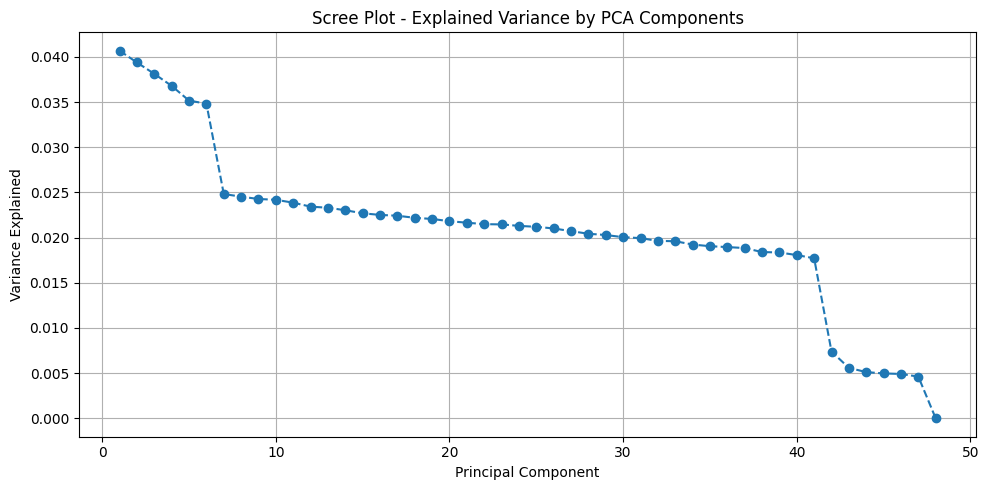

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load uncorrelated dataset or full numeric data
df = pd.read_csv('../data/uncorrelated_features.csv', index_col=0)
df_scaled = StandardScaler().fit_transform(df)

# PCA
pca = PCA()
pca.fit(df_scaled)

# Scree Plot
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), 
         pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title('Scree Plot - Explained Variance by PCA Components')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.grid(True)
plt.tight_layout()
plt.show()


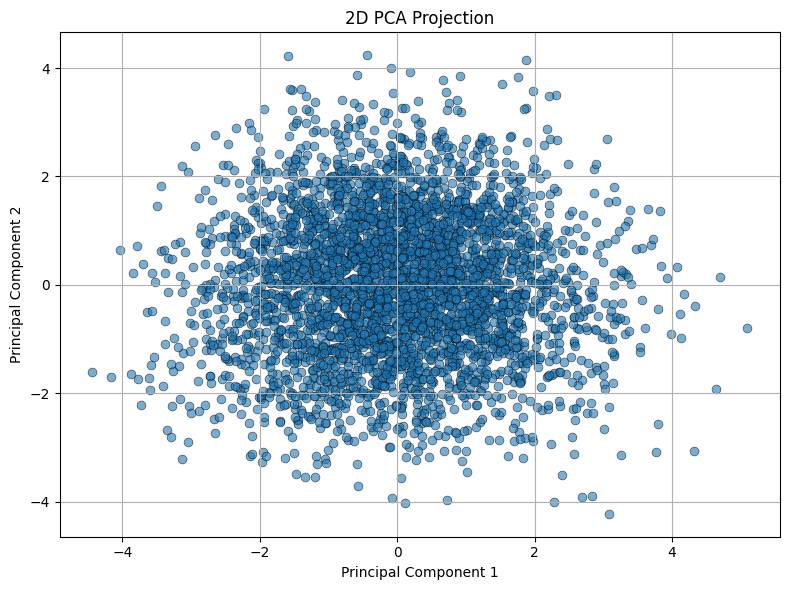

In [15]:
import seaborn as sns
from sklearn.decomposition import PCA

# Reduce to 2 components
pca_2d = PCA(n_components=2)
components = pca_2d.fit_transform(df_scaled)

# Create a DataFrame
pca_df = pd.DataFrame(data=components, columns=['PC1', 'PC2'])

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', data=pca_df, s=40, alpha=0.6, edgecolor='k')
plt.title('2D PCA Projection')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.tight_layout()
plt.show()


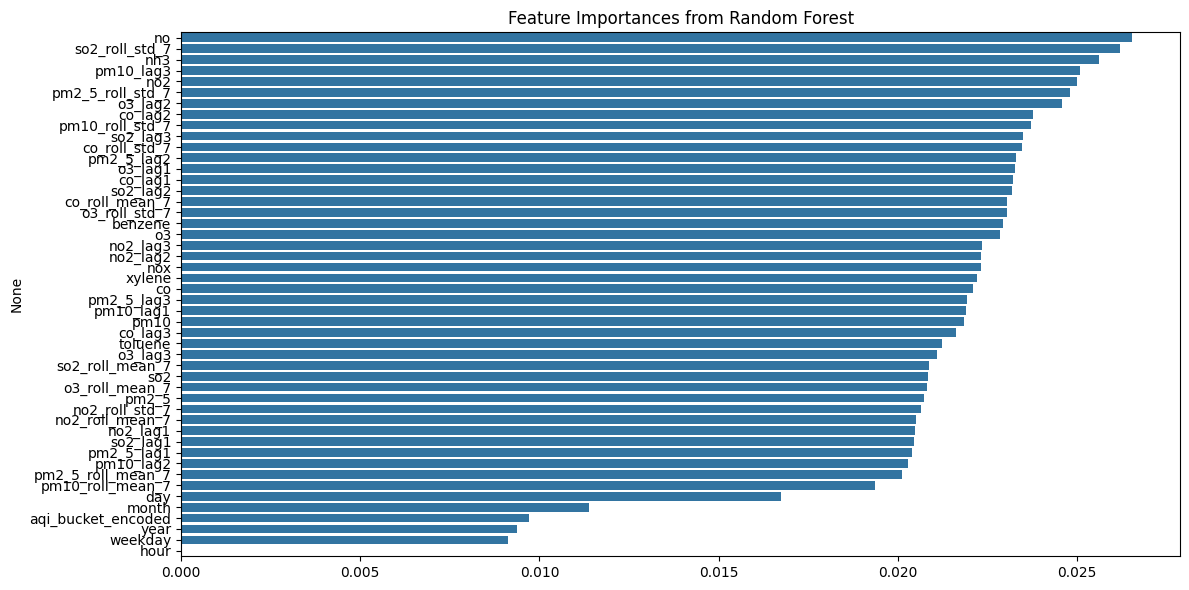

✅ Top 10 features saved to '../data/top_features.csv'


In [3]:
# Train-test split
from sklearn.model_selection import train_test_split

X = df_numeric.drop(columns=['aqi'])
y = df_numeric['aqi']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Feature importance
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=importances[indices], y=X.columns[indices])
plt.title("Feature Importances from Random Forest")
plt.tight_layout()
plt.show()

# Save top 10 features
top_features = X.columns[indices[:10]]
df_top = df[top_features]
df_top.to_csv('../data/top_features.csv')
print("Top 10 features saved to '../data/top_features.csv'")


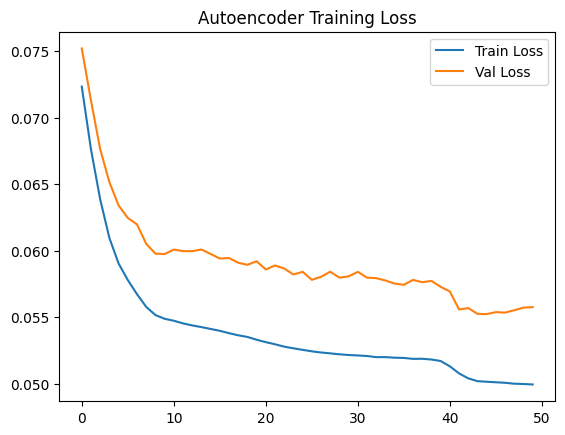

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Autoencoder features saved to '../data/autoencoder_features.csv'


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# Normalize features between 0 and 1
df = pd.read_csv('../data/feature_engineered_data.csv', parse_dates=['Date'])
df_numeric = df.select_dtypes(include=[np.number]).dropna()
scaler_ae = MinMaxScaler()
X_scaled = scaler_ae.fit_transform(df_numeric)

# Define Autoencoder architecture
input_dim = X_scaled.shape[1]
encoding_dim = 10  # You can tune this

input_layer = Input(shape=(input_dim,))
encoded = Dense(64, activation='relu')(input_layer)
encoded = Dense(encoding_dim, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
encoder = Model(inputs=input_layer, outputs=encoded)

# Compile and train
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

history = autoencoder.fit(X_scaled, X_scaled,
                          epochs=50,
                          batch_size=128,
                          shuffle=True,
                          validation_split=0.1,
                          verbose=0)

# Plotting loss (optional but recommended)
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Autoencoder Training Loss")
plt.show()

# Extract encoded (compressed) features
encoded_features = encoder.predict(X_scaled)
autoencoder_df = pd.DataFrame(encoded_features, index=df.index)
autoencoder_df.to_csv('../data/autoencoder_features.csv')

print("Autoencoder features saved to '../data/autoencoder_features.csv'")
#Saving the trained autoencoder model

In [12]:
import pandas as pd
import numpy as np  #

# Load the feature-engineered data
df = pd.read_csv('../data/feature_engineered_data.csv', parse_dates=['Date'])
df_numeric = df.select_dtypes(include='number')

# Compute correlation matrix
corr_matrix = df_numeric.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

# Find features with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

# Drop those features
df_uncorr = df_numeric.drop(columns=to_drop)

# Save the reduced dataset
df_uncorr.to_csv('../data/uncorrelated_features.csv', index=False)

print(f" Removed {len(to_drop)} highly correlated features:")
print(to_drop)
print("Saved to '../data/uncorrelated_features.csv'")


 Removed 0 highly correlated features:
[]
Saved to '../data/uncorrelated_features.csv'
